In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from PLUME_function import *

%matplotlib inline

from sklearn import linear_model

## Data importing

In [198]:
X_train_train = pd.read_csv('sample data/X_train_train.csv')
X_train_test = pd.read_csv('sample data/X_train_test.csv')
Y_train_train = pd.read_csv('sample data/Y_train_train.csv')
Y_train_test = pd.read_csv('sample data/X_train_test.csv')

In [679]:
var = 'NO2-is-day-month-wind-XPrecipIntensity_04143-XPrecipProbability_04143'
objet_predict = "NO2"
X_train = pd.get_dummies(DataSample(X_train_train,var)).values
#X_train = X_train_train.iloc[:,1:]
Y_train = DataSample(Y_train_train,objet_predict).values

X_test = pd.get_dummies(DataSample(X_train_test,var)).values
#X_test = X_train_test.iloc[:,1:]
Y_test = DataSample(Y_train_test,objet_predict).values



In [680]:
X_train.shape

(3011, 1128)

## MLP (fully connected)

In [681]:
def tanh(x):
    return np.tanh(x)

def tanh_deriv(x):
    return 1.0 - np.tanh(x)**2

def logistic(x):
    return 1/(1 + np.exp(-x))

def logistic_derivative(x):
    return logistic(x)*(1-logistic(x))
def linear(x):
    return x/300.0
def linear_deriv(x):
    return np.float64(1/300.0)

class NeuralNetwork:
    def __init__(self, layers, activation='tanh'):
        """
        :param layers: A list containing the number of units in each layer.
        Should be at least two values
        :param activation: The activation function to be used. Can be
        "logistic" or "tanh"
        """
        if activation == 'logistic':
            self.activation = logistic
            self.activation_deriv = logistic_derivative
        elif activation == 'tanh':
            self.activation = tanh
            self.activation_deriv = tanh_deriv
        elif activation == 'linear':
            self.activation = linear
            self.activation_deriv = linear_deriv

        self.weights = []
        for i in range(1, len(layers) - 1):
            self.weights.append((2*np.random.random((layers[i - 1] + 1, layers[i]
                                + 1))-1)*0.25)
        self.weights.append((2*np.random.random((layers[i] + 1, layers[i +
                            1]))-1)*0.25)
    def fit(self, X, y, learning_rate=0.2, epochs=1000):
        X = np.atleast_2d(X)
        temp = np.ones([X.shape[0], X.shape[1]+1])
        temp[:, 0:-1] = X  # adding the bias unit to the input layer
        X = temp
        y = np.array(y)

        for k in range(epochs):
            i = np.random.randint(X.shape[0])
            a = [X[i]]

            for l in range(len(self.weights)):
                a.append(self.activation(np.dot(a[l], self.weights[l])))
            error = y[i] - a[-1]
            deltas = [error * self.activation_deriv(a[-1])]
           

            for l in range(len(a) - 2, 0, -1): # we need to begin at the second to last layer
                deltas.append(deltas[-1].dot(self.weights[l].T)*self.activation_deriv(a[l]))
            deltas.reverse()
            for i in range(len(self.weights)):
                layer = np.atleast_2d(a[i])
                delta = np.atleast_2d(deltas[i])
                self.weights[i] += learning_rate * layer.T.dot(delta)
    def predict(self, x):
        x = np.array(x)
        temp = np.ones(x.shape[0]+1)
        temp[0:-1] = x
        a = temp
        for l in range(0, len(self.weights)):
            a = self.activation(np.dot(a, self.weights[l]))

        return a

In [682]:
hour = 24
Y_hour_train = Y_train[:,hour-1]
Y_hour_test = Y_test[:,hour-1]

In [683]:
nn = NeuralNetwork([np.shape(X_train)[1],200,1], 'linear')


nn.fit(X_train, Y_hour_train,learning_rate=0.05,epochs=6000)


MSE = 0 

for i in range(len(Y_hour_test)):
    MSE += (Y_hour_test[i] - nn.predict(X_test[i])) ** 2
print 'MSE(MLP) :', MSE/float(len(Y_hour_test))


MSE(MLP) : [ 137.87304771]


In [684]:
id = 13
print nn.predict(X_test[id])
print Y_hour_test[id]

[ 45.41635906]
50.0


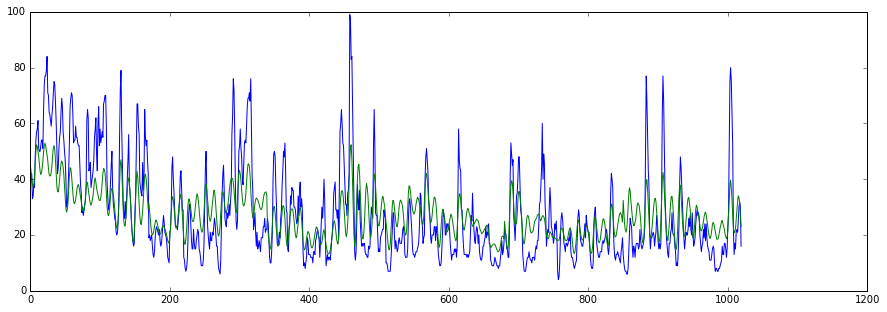

In [685]:
plt.figure(figsize = [15,5])
plt.plot(Y_hour_test)
plt.plot([nn.predict(X_test[id]) for id in range(len(Y_hour_test))])

# The Final Model

## For NO2

In [693]:
MSE_NO2 = 0 


var = 'NO2-is-day-month-wind-XPrecipIntensity_04143-XPrecipProbability_04143'
objet_predict = "NO2"

X_train = pd.get_dummies(DataSample(X_train_train,var)).values
#X_train = X_train_train.iloc[:,1:]
Y_train = DataSample(Y_train_train,objet_predict).values

X_test = pd.get_dummies(DataSample(X_train_test,var)).values
#X_test = X_train_test.iloc[:,1:]
Y_test = DataSample(Y_train_test,objet_predict).values


for hour in range(24):
    Y_hour_train = Y_train[:,hour]
    Y_hour_test = Y_test[:,hour]

    nn = NeuralNetwork([np.shape(X_train)[1],110,1], 'linear')
    nn.fit(X_train, Y_hour_train,learning_rate=0.05,epochs=6000)

    for i in range(len(Y_hour_test)):
        MSE_NO2 += (Y_hour_test[i] - nn.predict(X_test[i])) ** 2




## For O3

In [694]:
MSE_O3 = 0 


var = 'O3-is-day-month-wind-XPrecipIntensity_04143-XPrecipProbability_04143'
objet_predict = "O3"

X_train = pd.get_dummies(DataSample(X_train_train,var)).values
#X_train = X_train_train.iloc[:,1:]
Y_train = DataSample(Y_train_train,objet_predict).values

X_test = pd.get_dummies(DataSample(X_train_test,var)).values
#X_test = X_train_test.iloc[:,1:]
Y_test = DataSample(Y_train_test,objet_predict).values


for hour in range(24):
    Y_hour_train = Y_train[:,hour]
    Y_hour_test = Y_test[:,hour]

    nn = NeuralNetwork([np.shape(X_train)[1],110,1], 'linear')
    nn.fit(X_train, Y_hour_train,learning_rate=0.05,epochs=6000)

    for i in range(len(Y_hour_test)):
        MSE_O3 += (Y_hour_test[i] - nn.predict(X_test[i])) ** 2





## For PM2.5

In [695]:
MSE_PM2_5 = 0 


var = 'PM2-is-day-month-wind-XPrecipIntensity_04143-XPrecipProbability_04143'
objet_predict = "PM2"

X_train = pd.get_dummies(DataSample(X_train_train,var)).values
#X_train = X_train_train.iloc[:,1:]
Y_train = DataSample(Y_train_train,objet_predict).values

X_test = pd.get_dummies(DataSample(X_train_test,var)).values
#X_test = X_train_test.iloc[:,1:]
Y_test = DataSample(Y_train_test,objet_predict).values


for hour in range(24):
    Y_hour_train = Y_train[:,hour]
    Y_hour_test = Y_test[:,hour]

    nn = NeuralNetwork([np.shape(X_train)[1],110,1], 'linear')
    nn.fit(X_train, Y_hour_train,learning_rate=0.05,epochs=6000)

    for i in range(len(Y_hour_test)):
        MSE_PM2_5 += (Y_hour_test[i] - nn.predict(X_test[i])) ** 2






## For PM10

In [696]:
MSE_PM10 = 0 


var = 'PM10-is-day-month-wind-XPrecipIntensity_04143-XPrecipProbability_04143'
objet_predict = "PM10"

X_train = pd.get_dummies(DataSample(X_train_train,var)).values
#X_train = X_train_train.iloc[:,1:]
Y_train = DataSample(Y_train_train,objet_predict).values

X_test = pd.get_dummies(DataSample(X_train_test,var)).values
#X_test = X_train_test.iloc[:,1:]
Y_test = DataSample(Y_train_test,objet_predict).values


for hour in range(24):
    Y_hour_train = Y_train[:,hour]
    Y_hour_test = Y_test[:,hour]

    nn = NeuralNetwork([np.shape(X_train)[1],110,1], 'linear')
    nn.fit(X_train, Y_hour_train,learning_rate=0.05,epochs=6000)

    for i in range(len(Y_hour_test)):
        MSE_PM10 += (Y_hour_test[i] - nn.predict(X_test[i])) ** 2







## Conclusion

In [697]:
MSE = MSE_NO2 + MSE_O3 + MSE_PM2_5 + MSE_PM10
MSE = MSE/(float(len(Y_hour_test)))
print "MSE:",MSE

MSE: [ 16560.7196764]
